In [ ]:
access_token = ""

In [2]:
idCuda = "3, 4, 5"
idTorch = 0

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = f"{str(idCuda)}"

In [4]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, default_data_collator, EarlyStoppingCallback, IntervalStrategy
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score # Import all needed metrics
#from torch.utils.data import DataLoader, Dataset

In [5]:
torch.cuda.device_count()

3

In [6]:
torch.cuda.empty_cache()
torch.cuda.set_device(idTorch)

if torch.cuda.is_available():
    GPU = torch.cuda.get_device_name(idTorch)
    print(f"PyTorch available GPU: {GPU}")
else:
    print("GPU not available")

PyTorch available GPU: NVIDIA RTX A6000


In [7]:
device = torch.device(f"cuda:{idTorch}" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')

Device: cuda:0


In [8]:
topicos = True
fiveOrTree = False
classes = 3
classCol = 'sentiment'
if fiveOrTree:
    classes = 5
    classCol = 'scoreSA'

In [9]:
test_size = 0.2
locationOriginalDataset = '/home/patrick.araujo/topicModeling/trainTesting/export_outS_AmazonAutoRO_3_classeALL.csv'
print(f'Usando para o cojunto de teste {100-test_size*100}% e validação {test_size*100}% de:  "{locationOriginalDataset}"')
dataset = pd.read_csv(locationOriginalDataset)

Usando para o cojunto de teste 80.0% e validação 20.0% de:  "/home/patrick.araujo/topicModeling/trainTesting/export_outS_AmazonAutoRO_3_classeALL.csv"


In [10]:
dataset

,level_0,index,Unnamed: 0,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,sentiment,lengthContent,Language,scoreSA,topics
0,7339,7608.0,11121.0,17630,Donna Brown,https://play-lh.googleusercontent.com/a/ACg8oc...,It was simple to access once I figured it out.,5,0.0,26.21.0.100,2023-10-29 18:59:35,NaN,NaN,26.21.0.100,2,46,en,4,"['app', 'amazon', 'love', 'great', 'need', 'go..."
1,11432,11843.0,17077.0,17283,Rene Cesar,https://play-lh.googleusercontent.com/a-/ALV-U...,Besides finding almost everything on here it's...,2,4.0,26.9.0.100,2023-04-28 22:48:57,NaN,NaN,26.9.0.100,0,463,en,1,"['app', 'amazon', 'just', 'don', 'search', 'ti..."
2,240,NaN,NaN,9682,NaN,NaN,"i have to go with android settings, then upgra...",3,NaN,NaN,NaN,NaN,NaN,NaN,1,218,NaN,2,"['app', 'amazon', 'just', 'like', 'don', 'time..."
3,10173,10543.0,15523.0,3230,Michecoe Cole,https://play-lh.googleusercontent.com/a/ACg8oc...,I ordered a package on the 26th and it said it...,2,1.0,26.13.6.100,2023-06-29 12:32:45,NaN,NaN,26.13.6.100,0,215,en,1,"['app', 'amazon', 'just', 'search', 'update', ..."
4,9327,9655.0,14390.0,13462,Aaron Lamb,https://play-lh.googleusercontent.com/a/ACg8oc...,DON'T UPGRADE! Even...slower...still... Why di...,2,4.0,26.15.0.100,2023-08-10 12:58:47,NaN,NaN,26.15.0.100,0,441,en,1,"['app', 'amazon', 'just', 'search', 'update', ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24067,4158,4322.0,6304.0,5955,Katie Barlow,https://play-lh.googleusercontent.com/a-/ALV-U...,"Doesn't work after update. Crashes, freezes, c...",1,0.0,24.8.0.100,2023-11-23 17:24:17,NaN,NaN,24.8.0.100,0,169,en,0,"['app', 'amazon', 'just', 'don', 'search', 'ti..."
24068,10313,10685.0,15697.0,9792,Kyle S,https://play-lh.googleusercontent.com/a-/ALV-U...,Poor UI Design Choice The search bar is now fi...,3,30.0,26.13.0.100,2023-06-23 10:03:46,NaN,NaN,26.13.0.100,1,269,en,2,"['app', 'amazon', 'just', 'time', 'like', 'ord..."
24069,3414,NaN,NaN,23376,NaN,NaN,my amazon watch app is back when me'm in their...,3,NaN,NaN,NaN,NaN,NaN,NaN,1,68,NaN,2,"['app', 'amazon', 'just', 'time', 'like', 'ord..."
24070,16458,17039.0,24319.0,15523,Laurie KELSEY Myers,https://play-lh.googleusercontent.com/a/ACg8oc...,You MUST ENSURE I R receiving FREE SHIPPING U ...,3,2.0,24.10.2.100,2022-06-01 13:39:14,NaN,NaN,24.10.2.100,1,339,en,2,"['app', 'amazon', 'just', 'time', 'like', 'ord..."


In [11]:
dataset.shape

(24072, 19)

In [12]:
score_counts_balanced = dataset['scoreSA'].value_counts().sort_index()
print(score_counts_balanced)

scoreSA
0    3723
1    4301
2    8024
3    4530
4    3494
Name: count, dtype: int64


In [13]:
sentiments_counts_balanced = dataset['sentiment'].value_counts().sort_index()
print(sentiments_counts_balanced)

sentiment
0    8024
1    8024
2    8024
Name: count, dtype: int64


In [14]:
generated_RO = dataset[dataset['index'].isna()]
df_original = dataset[~dataset['index'].isna()]

score_dfO_counts_balanced = df_original[classCol].value_counts().sort_index()
highest_count = score_dfO_counts_balanced.max()
highest_value = score_dfO_counts_balanced[score_dfO_counts_balanced == highest_count].index[0]

In [15]:
train_data_AllC = None
val_data_AllC = None

df_filtered_scMAX = df_original[df_original[classCol] == highest_value].reset_index(drop=True)
train_dataMAX, val_dataMAX = train_test_split(df_filtered_scMAX, test_size=test_size, random_state=42)

all_dfs_Train = []
all_dfs_Val = []

all_dfs_Train.append(train_dataMAX)
all_dfs_Val.append(val_dataMAX)

for score_value, count in score_dfO_counts_balanced.items():
    if (highest_value != score_value):
        df_filtered_scTemp = df_original[df_original[classCol] == score_value].reset_index(drop=True)
        train_dataTemp, val_dataTemp = train_test_split(df_filtered_scTemp, test_size=len(val_dataMAX), train_size=None, random_state=42)
        remainingGenRO = generated_RO[generated_RO[classCol] == score_value].reset_index(drop=True)
        merged_df = pd.concat([remainingGenRO, train_dataTemp])
        merged_df = merged_df.reset_index(drop=True)
        merged_df = merged_df.sample(frac=1)
        val_dataTemp = val_dataTemp.sample(frac=1)
        all_dfs_Train.append(merged_df)
        all_dfs_Val.append(val_dataTemp)
combined_df_Train = pd.concat(all_dfs_Train, ignore_index=True)
combined_df_Train = combined_df_Train.sample(frac=1)
train_data_AllC = combined_df_Train.reset_index(drop=True)
combined_df_Val = pd.concat(all_dfs_Val, ignore_index=True)
combined_df_Val = combined_df_Val.sample(frac=1)
val_data_AllC = combined_df_Val.reset_index(drop=True)

In [16]:
train_data_AllC

,level_0,index,Unnamed: 0,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,sentiment,lengthContent,Language,scoreSA,topics
0,13277,13756.0,19538.0,3975,Lance McLaren Meléndez,https://play-lh.googleusercontent.com/a-/ALV-U...,I don't like that is not available English in ...,3,0.0,24.22.0.100,2022-12-17 18:57:44,NaN,NaN,24.22.0.100,1,132,en,2,"['app', 'amazon', 'just', 'like', 'don', 'time..."
1,14429,14933.0,21067.0,18590,Miss Zee,https://play-lh.googleusercontent.com/a-/ALV-U...,Use to LOVE. Now I'm having issues constantly....,2,0.0,NaN,2022-10-10 10:07:18,NaN,NaN,NaN,0,417,en,1,"['app', 'amazon', 'just', 'don', 'search', 'ti..."
2,2618,NaN,NaN,8303,NaN,NaN,"new update not having a beta curve, but both u...",3,NaN,NaN,NaN,NaN,NaN,NaN,1,280,NaN,2,"['app', 'amazon', 'just', 'time', 'like', 'ord..."
3,10892,11274.0,16390.0,949,Cheryl G,https://play-lh.googleusercontent.com/a-/ALV-U...,"Not sure what happened in the last update, but...",3,1.0,26.11.0.100,2023-06-03 21:15:45,NaN,NaN,26.11.0.100,1,287,en,2,"['app', 'amazon', 'just', 'like', 'don', 'time..."
4,3743,3886.0,5665.0,4105,MariaJose Machado,https://play-lh.googleusercontent.com/a/ACg8oc...,It exist on my phone but it would.not open,2,0.0,NaN,2023-11-27 15:42:58,NaN,NaN,NaN,0,42,en,1,"['app', 'amazon', 'just', 'don', 'search', 'ti..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19252,13170,13645.0,19400.0,16966,Riley Martin,https://play-lh.googleusercontent.com/a/ACg8oc...,From late to lost packages. From false adverti...,2,1.0,24.22.0.100,2022-12-24 20:34:45,NaN,NaN,24.22.0.100,0,106,en,1,"['app', 'amazon', 'just', 'search', 'update', ..."
19253,10452,10827.0,15874.0,10449,Lori Davis,https://play-lh.googleusercontent.com/a/ACg8oc...,"Stop moving things! The app is fine, but it fe...",2,2.0,26.12.0.100,2023-06-17 13:48:48,NaN,NaN,26.12.0.100,0,137,en,1,"['app', 'amazon', 'just', 'don', 'search', 'ti..."
19254,16797,17387.0,24849.0,21538,Zach Rocchetti,https://play-lh.googleusercontent.com/a/ACg8oc...,need to bring back the return stuff for clothes,3,0.0,24.9.0.100,2022-05-12 06:26:00,NaN,NaN,24.9.0.100,1,47,en,2,"['app', 'amazon', 'just', 'like', 'don', 'time..."
19255,15855,16414.0,23305.0,5415,Ashley Ables,https://play-lh.googleusercontent.com/a-/ALV-U...,The price at check out doesn't always automate...,4,0.0,22.13.0.100,2022-07-05 21:20:46,NaN,NaN,22.13.0.100,2,96,en,3,"['amazon', 'app', 'shopping', 'love', 'great',..."


In [17]:
val_data_AllC

,level_0,index,Unnamed: 0,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,sentiment,lengthContent,Language,scoreSA,topics
0,12653,13106.0,18698.0,19008,Nova Leavens,https://play-lh.googleusercontent.com/a/ACg8oc...,Not a bad app for getting stuff but some thing...,4,0.0,26.2.0.100,2023-01-29 19:35:50,NaN,NaN,26.2.0.100,2,106,en,3,"['amazon', 'app', 'shopping', 'love', 'great',..."
1,10068,10430.0,15391.0,13664,Samantha Garl,https://play-lh.googleusercontent.com/a-/ALV-U...,"Long time member, not happy anymore. We pay hu...",2,0.0,26.13.6.100,2023-07-04 15:28:45,NaN,NaN,26.13.6.100,0,418,en,1,"['app', 'amazon', 'just', 'search', 'update', ..."
2,462,474.0,729.0,5117,Honey Bee,https://play-lh.googleusercontent.com/a-/ALV-U...,My go to but be aware if yo pocket hurt cuz th...,5,0.0,26.23.4.100,2024-01-03 14:50:12,NaN,NaN,26.23.4.100,2,64,en,4,"['amazon', 'app', 'shopping', 'love', 'great',..."
3,11220,11624.0,16810.0,15094,The House Of Phoenix Spiritual Life After Trauma,https://play-lh.googleusercontent.com/a-/ALV-U...,Love Amazon !!!! They have a new icon..inspire...,4,7.0,26.10.2.100,2023-05-16 12:53:45,NaN,NaN,26.10.2.100,2,306,en,3,"['app', 'amazon', 'love', 'great', 'need', 'go..."
4,7296,7563.0,11035.0,1557,Tiffany Turner,https://play-lh.googleusercontent.com/a-/ALV-U...,I love the app and I get all my items on time,5,0.0,26.21.0.100,2023-10-31 07:55:49,NaN,NaN,26.21.0.100,2,45,en,4,"['app', 'amazon', 'love', 'great', 'need', 'go..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4810,5962,6211.0,9253.0,16904,Haylie Watkins,https://play-lh.googleusercontent.com/a/ACg8oc...,The app keeps crashing idk why everytime I get...,1,0.0,26.21.0.100,2023-11-06 22:22:22,NaN,NaN,26.21.0.100,0,115,en,0,"['app', 'amazon', 'just', 'search', 'update', ..."
4811,14193,14694.0,20754.0,17801,Lisa S,https://play-lh.googleusercontent.com/a-/ALV-U...,Fix the bugs. It's glitching... It's still gli...,3,1.0,24.19.0.100,2022-10-24 19:05:13,NaN,NaN,24.19.0.100,1,53,en,2,"['app', 'amazon', 'just', 'time', 'like', 'ord..."
4812,8680,8980.0,13520.0,5262,Beth Nagy,https://play-lh.googleusercontent.com/a-/ALV-U...,The app is hard to use and they took out the o...,3,0.0,NaN,2023-09-17 15:01:49,NaN,NaN,NaN,1,118,en,2,"['app', 'amazon', 'just', 'like', 'don', 'time..."
4813,7212,7476.0,10871.0,5960,Andrew,https://play-lh.googleusercontent.com/a-/ALV-U...,Linking Blizzard to Amazon and unlink are very...,5,1.0,26.21.0.100,2023-11-02 13:44:49,NaN,NaN,26.21.0.100,2,235,en,4,"['amazon', 'app', 'shopping', 'love', 'great',..."


In [18]:
print(val_data_AllC[val_data_AllC['index'].isna()])

Empty DataFrame
Columns: [level_0, index, Unnamed: 0, reviewId, userName, userImage, content, score, thumbsUpCount, reviewCreatedVersion, at, replyContent, repliedAt, appVersion, sentiment, lengthContent, Language, scoreSA, topics]
Index: []


In [19]:
train_data = None
val_data = None

if topicos:
    train_data = train_data_AllC[['content', 'topics', classCol]]
    val_data = val_data_AllC[['content', 'topics', classCol]]
else:
    train_data = train_data_AllC[['content', classCol]]
    val_data = val_data_AllC[['content', classCol]]

In [20]:
# Load the pre-trained BERT model and tokenizer
model_name = "google-t5/t5-small"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5, token=access_token)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at google-t5/t5-small and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
# Move model to GPU
model = model.to(device)

In [22]:
print("Training Data")
print(train_data[classCol].value_counts().sort_index())
print("\nValidation Data")
print(val_data[classCol].value_counts().sort_index())

Training Data
sentiment
0    6419
1    6419
2    6419
Name: count, dtype: int64

Validation Data
sentiment
0    1605
1    1605
2    1605
Name: count, dtype: int64


In [23]:
train_data

,content,topics,sentiment
0,I don't like that is not available English in ...,"['app', 'amazon', 'just', 'like', 'don', 'time...",1
1,Use to LOVE. Now I'm having issues constantly....,"['app', 'amazon', 'just', 'don', 'search', 'ti...",0
2,"new update not having a beta curve, but both u...","['app', 'amazon', 'just', 'time', 'like', 'ord...",1
3,"Not sure what happened in the last update, but...","['app', 'amazon', 'just', 'like', 'don', 'time...",1
4,It exist on my phone but it would.not open,"['app', 'amazon', 'just', 'don', 'search', 'ti...",0
...,...,...,...
19252,From late to lost packages. From false adverti...,"['app', 'amazon', 'just', 'search', 'update', ...",0
19253,"Stop moving things! The app is fine, but it fe...","['app', 'amazon', 'just', 'don', 'search', 'ti...",0
19254,need to bring back the return stuff for clothes,"['app', 'amazon', 'just', 'like', 'don', 'time...",1
19255,The price at check out doesn't always automate...,"['amazon', 'app', 'shopping', 'love', 'great',...",2


In [24]:
val_data

,content,topics,sentiment
0,Not a bad app for getting stuff but some thing...,"['amazon', 'app', 'shopping', 'love', 'great',...",2
1,"Long time member, not happy anymore. We pay hu...","['app', 'amazon', 'just', 'search', 'update', ...",0
2,My go to but be aware if yo pocket hurt cuz th...,"['amazon', 'app', 'shopping', 'love', 'great',...",2
3,Love Amazon !!!! They have a new icon..inspire...,"['app', 'amazon', 'love', 'great', 'need', 'go...",2
4,I love the app and I get all my items on time,"['app', 'amazon', 'love', 'great', 'need', 'go...",2
...,...,...,...
4810,The app keeps crashing idk why everytime I get...,"['app', 'amazon', 'just', 'search', 'update', ...",0
4811,Fix the bugs. It's glitching... It's still gli...,"['app', 'amazon', 'just', 'time', 'like', 'ord...",1
4812,The app is hard to use and they took out the o...,"['app', 'amazon', 'just', 'like', 'don', 'time...",1
4813,Linking Blizzard to Amazon and unlink are very...,"['amazon', 'app', 'shopping', 'love', 'great',...",2


In [25]:
max_length = 512

In [26]:
def tokenizerFunctionWithTopics(string, topics):
    # Tokenize using tokenizer function
    string_list = eval(topics)
    tokens = tokenizer.encode_plus(string, topics, padding='max_length', truncation=True, max_length=max_length, return_tensors="pt")
    return tokens

def tokenizerFunction(string):
    # Tokenize without topics
    tokens = tokenizer(string, padding='max_length', truncation=True, max_length=max_length, return_tensors="pt")
    return tokens

# Assuming train_data and val_data are defined somewhere in your code
train_encodings = train_data['content'].apply(tokenizerFunction)
if topicos:
    train_encodings = train_data.apply(lambda x: tokenizerFunctionWithTopics(x['content'], x['topics']), axis=1)
val_encodings = val_data['content'].apply(tokenizerFunction)

In [27]:
train_encodings

0        [input_ids, attention_mask]
1        [input_ids, attention_mask]
2        [input_ids, attention_mask]
3        [input_ids, attention_mask]
4        [input_ids, attention_mask]
                    ...             
19252    [input_ids, attention_mask]
19253    [input_ids, attention_mask]
19254    [input_ids, attention_mask]
19255    [input_ids, attention_mask]
19256    [input_ids, attention_mask]
Length: 19257, dtype: object

In [28]:
val_encodings

0       [input_ids, attention_mask]
1       [input_ids, attention_mask]
2       [input_ids, attention_mask]
3       [input_ids, attention_mask]
4       [input_ids, attention_mask]
                   ...             
4810    [input_ids, attention_mask]
4811    [input_ids, attention_mask]
4812    [input_ids, attention_mask]
4813    [input_ids, attention_mask]
4814    [input_ids, attention_mask]
Name: content, Length: 4815, dtype: object

In [29]:
def creatingDataframe(encodings):
  indices = encodings.index.to_numpy()

  df = pd.DataFrame(columns=['input_ids', 'attention_mask'])
  
  # Assuming 'content' is a Series or List containing tuples/lists
  for element in encodings:
    input_ids = element['input_ids'][0].numpy()              # Replace with correct index based on your data structure
    attention_mask = element['attention_mask'][0].numpy()    # Replace with correct index
    df.loc[len(df.index)] = [input_ids, attention_mask]
  df_index = pd.DataFrame(indices, columns=['index'])
  df['index'] = df_index['index']
  return df

# Batch Size

In [30]:
# Define batch size and create data loaders
batch_size = 16  # Adjust as needed

In [31]:
# Create datasets
# Convert labels to tensors
train_dataset = creatingDataframe(train_encodings)
train_labels = train_data[classCol].reset_index(name='label')
train_dataset = pd.merge(train_dataset, train_labels, on='index')

val_dataset = creatingDataframe(val_encodings)
val_labels = val_data[classCol].reset_index(name='label')
val_dataset = pd.merge(val_dataset, val_labels, on='index')

In [32]:
train_dataset = train_dataset.drop('index', axis=1)
val_dataset = val_dataset.drop('index', axis=1)

In [33]:
train_dataset

,input_ids,attention_mask,label
0,"[27, 278, 31, 17, 114, 24, 19, 59, 347, 1566, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
1,"[2048, 12, 10315, 5, 852, 27, 31, 51, 578, 807...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0
2,"[126, 2270, 59, 578, 3, 9, 12637, 8435, 6, 68,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
3,"[933, 417, 125, 2817, 16, 8, 336, 2270, 6, 68,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
4,"[94, 3223, 30, 82, 951, 68, 34, 133, 5, 2264, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0
...,...,...,...
19252,"[1029, 1480, 12, 1513, 6307, 5, 1029, 6136, 36...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0
19253,"[9078, 1735, 378, 55, 37, 1120, 19, 1399, 6, 6...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0
19254,"[174, 12, 830, 223, 8, 1205, 2005, 21, 4954, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
19255,"[37, 594, 44, 691, 91, 744, 31, 17, 373, 7791,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2


In [34]:
val_dataset

,input_ids,attention_mask,label
0,"[933, 3, 9, 1282, 1120, 21, 652, 2005, 68, 128...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2
1,"[3230, 97, 1144, 6, 59, 1095, 7595, 5, 101, 72...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0
2,"[499, 281, 12, 68, 36, 2718, 3, 99, 3, 63, 32,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2
3,"[2129, 2536, 3, 12887, 328, 43, 3, 9, 126, 670...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2
4,"[27, 333, 8, 1120, 11, 27, 129, 66, 82, 1173, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ...",2
...,...,...,...
4810,"[37, 1120, 5689, 3, 29126, 3, 23, 26, 157, 572...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0
4811,"[14269, 8, 13348, 5, 94, 31, 7, 28950, 53, 233...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
4812,"[37, 1120, 19, 614, 12, 169, 11, 79, 808, 91, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
4813,"[7505, 53, 272, 13287, 7061, 26, 12, 2536, 11,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2


In [35]:
train_dataset = Dataset.from_pandas(train_dataset)
val_dataset = Dataset.from_pandas(val_dataset)

In [36]:
path = ''

In [37]:
# Define training arguments with early stopping
training_args = TrainingArguments(
    # Positional arguments:
    output_dir= path+"./t5-small_sentiment_model",
    logging_dir= path+"./logs_t5s",
    #device=device,

    # Keyword arguments:
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    evaluation_strategy="epoch",
    #eval_steps=250,                         # Adjust as needed
    save_total_limit=2,                     # Adjust as needed. Only last 2 models are saved. Older ones are deleted.
    num_train_epochs=5,                     # Adjust as needed
    save_steps=500,                         # Adjust as needed
    metric_for_best_model="eval_loss",      # Use validation loss for early stopping
    learning_rate= 7e-05,
    warmup_steps=500,
    weight_decay=0.001,
    save_strategy="epoch",
    load_best_model_at_end=True
)

In [38]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_recall_fscore_support, mean_absolute_error

def compute_metrics(eval_preds):

    logits = eval_preds.predictions
    labels = eval_preds.label_ids
    # Convert logits to predicted labels
    
    predicted_labels = np.argmax(logits[0], axis=1)
    
    
    metrics = {}
    # Calculate accuracy
    accuracy = accuracy_score(labels, predicted_labels)
    # balanced_accuracy = balanced_accuracy_score(labels, predicted_labels)
    metrics['accuracy'] = accuracy
    # metrics['balanced_accuracy'] = balanced_accuracy

    # Calculate accuracy for each class
    class_accuracy = {}
    for i in range(len(np.unique(labels))):
        class_indices = np.where(labels == i)[0]
        class_accuracy[f'class_{i}'] = accuracy_score(labels[class_indices], predicted_labels[class_indices])
    
    # Calculate precision, recall, F1 score, and support for each class
    precision, recall, f1, support = precision_recall_fscore_support(labels, predicted_labels)    
    
    # Create a dictionary to store metrics for each class
    class_metrics = {}
    # Include class-wise accuracy in the metrics
    i = 0
    for class_name, acc in class_accuracy.items():
        class_metrics[f'class_{i}'] = {
            'accuracy': acc,
            'precision': precision[i],
            'recall': recall[i],
            'f1': f1[i],
            'support': support[i]
        }
        i = i+1

    precision_ALL = precision_score(labels, predicted_labels, average='macro')
    recall_ALL = recall_score(labels, predicted_labels, average='macro')
    f1_ALL = f1_score(labels, predicted_labels, average='macro')
    mae_ALL = mean_absolute_error(labels, predicted_labels)

    metrics['precision'] = precision_ALL
    metrics['recall'] = recall_ALL
    metrics['f1'] = f1_ALL
    metrics['mae'] = mae_ALL
    
    # Print and return the metrics
    for class_name, c_metrics in class_metrics.items():
        metrics[f'{class_name}_accuracy'] = c_metrics["accuracy"]
        metrics[f'{class_name}_precision'] = c_metrics["precision"]
        metrics[f'{class_name}_recall'] = c_metrics["recall"]
        metrics[f'{class_name}_f1'] = c_metrics["f1"]
        metrics[f'{class_name}_support'] = c_metrics["support"]

    return metrics

In [39]:
# Initialize the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=default_data_collator,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    # callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
)

In [40]:
# Fine-tune the model
trainer.train()

/home/patrick.araujo/miniconda3/envs/llama/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Mae,Class 0 Accuracy,Class 0 Precision,Class 0 Recall,Class 0 F1,Class 0 Support,Class 1 Accuracy,Class 1 Precision,Class 1 Recall,Class 1 F1,Class 1 Support,Class 2 Accuracy,Class 2 Precision,Class 2 Recall,Class 2 F1,Class 2 Support
1,No log,1.522547,0.336241,0.341022,0.336241,0.232124,0.959294,0.026791,0.352459,0.026791,0.049797,1605,0.105919,0.334646,0.105919,0.160909,1605,0.876012,0.335962,0.876012,0.485665,1605
2,0.518600,1.808952,0.339564,0.368766,0.339564,0.210746,0.973001,0.029907,0.432432,0.029907,0.055944,1605,0.044860,0.336449,0.044860,0.079164,1605,0.943925,0.337416,0.943925,0.497129,1605
3,0.027700,1.924500,0.335410,0.360051,0.335410,0.203476,0.980478,0.019938,0.415584,0.019938,0.038050,1605,0.044860,0.330275,0.044860,0.078991,1605,0.941433,0.334292,0.941433,0.493388,1605
4,0.009900,1.990430,0.336864,0.380055,0.336864,0.211626,0.975078,0.026791,0.472527,0.026791,0.050708,1605,0.053583,0.333333,0.053583,0.092324,1605,0.930218,0.334304,0.930218,0.491846,1605
5,0.004200,2.041240,0.335202,0.363116,0.335202,0.205572,0.980478,0.023053,0.425287,0.023053,0.043735,1605,0.046106,0.330357,0.046106,0.080919,1605,0.936449,0.333703,0.936449,0.492061,1605


/home/patrick.araujo/miniconda3/envs/llama/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/patrick.araujo/miniconda3/envs/llama/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/patrick.araujo/miniconda3/envs/llama/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/patrick.araujo/miniconda3/envs/llama/lib/python3.12/site-packages/torch/nn/p

TrainOutput(global_step=2010, training_loss=0.13941879460393494, metrics={'train_runtime': 1770.7276, 'train_samples_per_second': 54.376, 'train_steps_per_second': 1.135, 'total_flos': 1.310983441657344e+16, 'train_loss': 0.13941879460393494, 'epoch': 5.0})

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Use the trainer to predict labels on the validation dataset
predictions = trainer.predict(val_dataset)
logits = predictions[0]
predictions, labels = logits
predicted_labels = np.argmax(predictions, axis=1)
# Extract the true labels from the validation dataset
true_labels = val_dataset['label']

# Generate the confusion matrix
unique_labels = np.sort(dataset[classCol].unique())

conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=unique_labels)

print("Confusion Matrix:")
print(conf_matrix)
# Mapping from number to string

mapping = {0: 'Negative (0)', 1: 'Neutral (1)', 2: 'Positive (2)'}
if fiveOrTree:
    mapping = {0: 'Very Negative (1)', 1: 'Negative (2)', 2: 'Neutral (3)', 3: 'Positive (4)', 4: 'Very Positive (5)'}

# Applying mapping
classes = [mapping[value] for value in unique_labels]

/home/patrick.araujo/miniconda3/envs/llama/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Confusion Matrix:
[[  37   65 1503]
 [  33   74 1498]
 [  17   85 1503]]


In [42]:
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def cm_analysis(y_true, y_pred, filename, labels, classes, ymap=None, figsize=(17,17)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      classes:   aliases for the labels. String array to be shown in the cm plot.
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    sns.set(font_scale=2.8)

    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.2f%%\n%d/%d' % (p, c, s)
            #elif c == 0:
            #    annot[i, j] = ''
            else:
                annot[i, j] = '%.2f%%\n%d' % (p, c)
    cm = confusion_matrix(y_true, y_pred, labels=labels, normalize='true')
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm = cm * 100
    cm.index.name = 'True Label'
    cm.columns.name = 'Predicted Label'
    fig, ax = plt.subplots(figsize=figsize)
    plt.yticks(va='center')

    sns.heatmap(cm, annot=annot, fmt='', ax=ax, xticklabels=classes, cbar=True, cbar_kws={'format':PercentFormatter()}, yticklabels=classes, cmap="Blues")
    plt.savefig(f'{filename}.png',  bbox_inches='tight')
    plt.savefig(f'{filename}.svg',  bbox_inches='tight')

/home/patrick.araujo/llama2/ipykernel_3073466/703857389.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  annot[i, j] = '%.2f%%\n%d/%d' % (p, c, s)


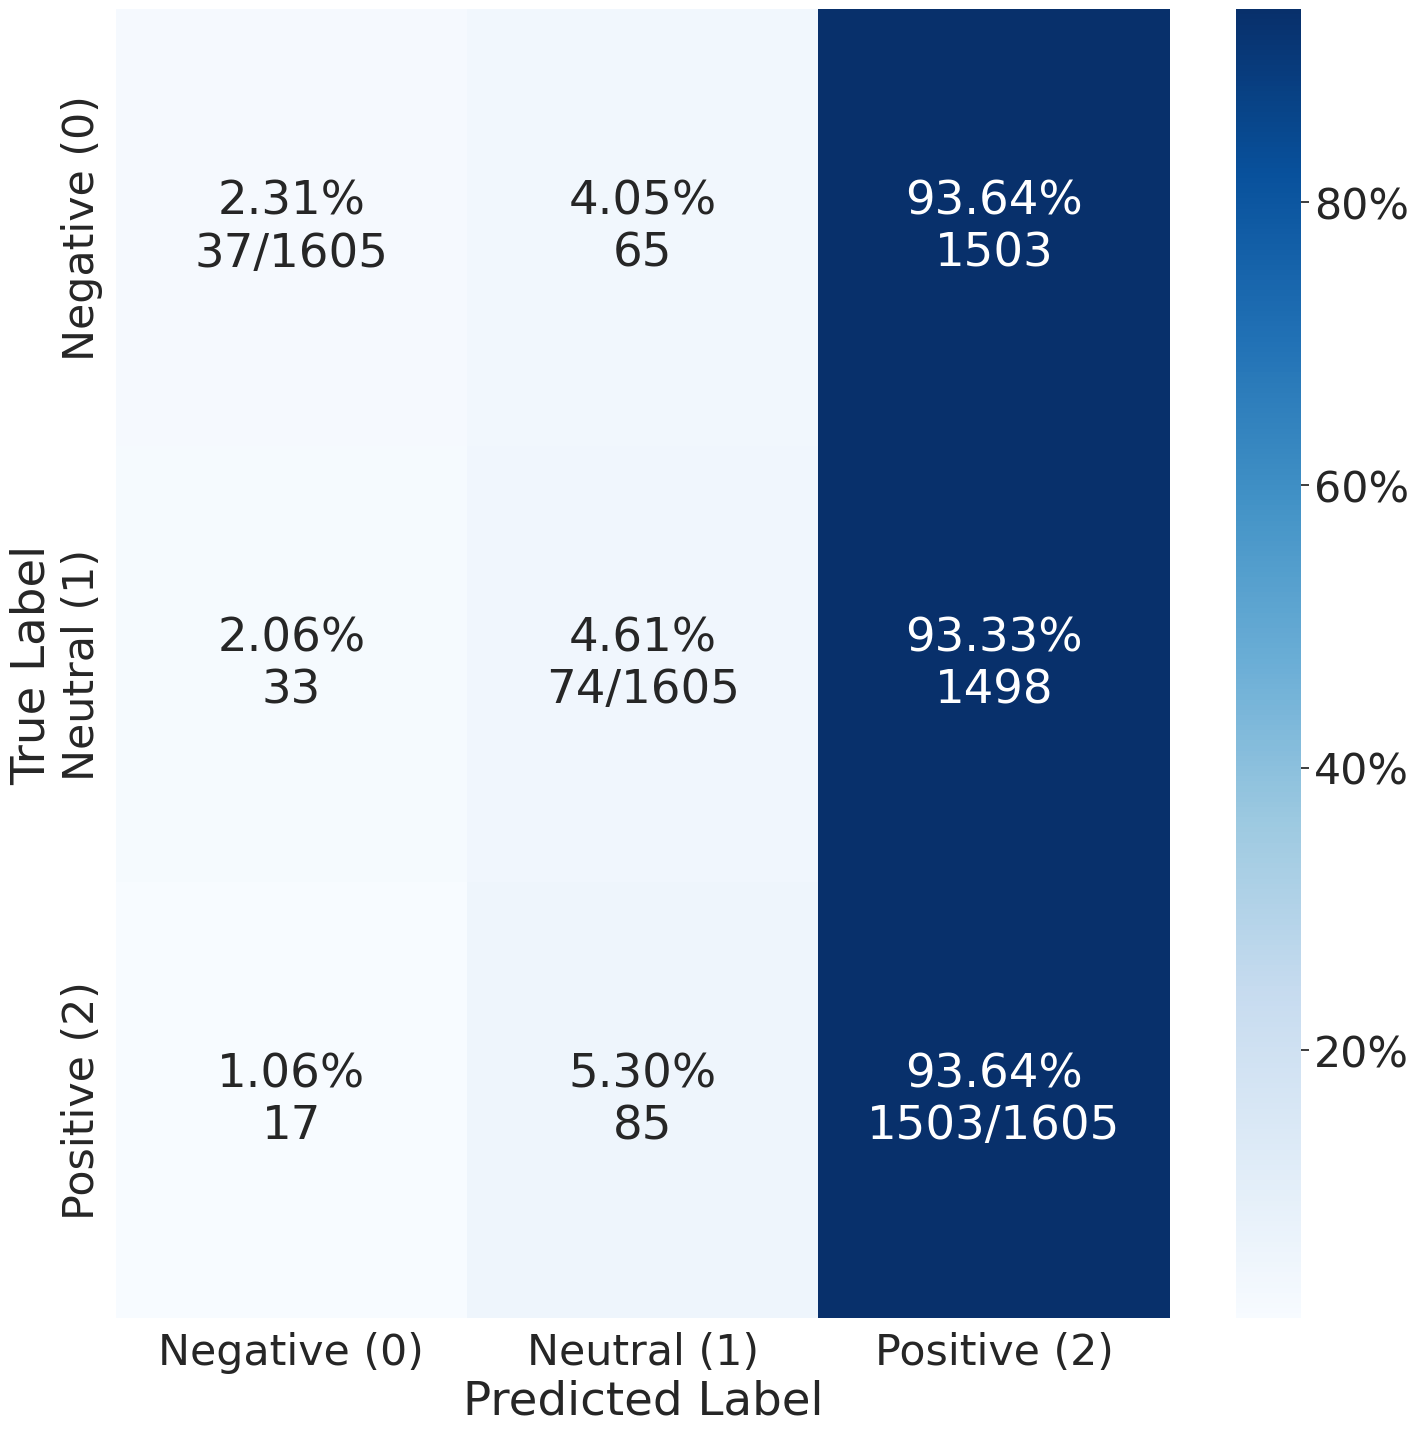

In [43]:
cm_analysis(true_labels, predicted_labels, 'confusion_matrix_t5', unique_labels, classes)

In [44]:
# Evaluate the model
results = trainer.evaluate()

/home/patrick.araujo/miniconda3/envs/llama/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [45]:
results

{'eval_loss': 2.0412399768829346,
 'eval_accuracy': 0.335202492211838,
 'eval_precision': 0.3631159579856524,
 'eval_recall': 0.335202492211838,
 'eval_f1': 0.2055715510226713,
 'eval_mae': 0.9804776739356179,
 'eval_class_0_accuracy': 0.023052959501557634,
 'eval_class_0_precision': 0.42528735632183906,
 'eval_class_0_recall': 0.023052959501557634,
 'eval_class_0_f1': 0.04373522458628842,
 'eval_class_0_support': 1605,
 'eval_class_1_accuracy': 0.04610591900311527,
 'eval_class_1_precision': 0.33035714285714285,
 'eval_class_1_recall': 0.04610591900311527,
 'eval_class_1_f1': 0.08091853471842538,
 'eval_class_1_support': 1605,
 'eval_class_2_accuracy': 0.9364485981308411,
 'eval_class_2_precision': 0.3337033747779751,
 'eval_class_2_recall': 0.9364485981308411,
 'eval_class_2_f1': 0.49206089376330003,
 'eval_class_2_support': 1605,
 'eval_runtime': 38.5357,
 'eval_samples_per_second': 124.949,
 'eval_steps_per_second': 2.621,
 'epoch': 5.0}

In [46]:
output_file_path = './t5-small_sentiment_model'
destination = path+output_file_path

# Save the model
model.save_pretrained(destination)

In [47]:
topics_counts_balanced = dataset['topics'].value_counts().sort_index()
print(len(topics_counts_balanced))

381
